In [1]:
TRAIN = False

# Utility 
import os
import tqdm
import pickle
from typing import List

# Data manipulation
import pandas as pd
import numpy as np

# Scientific
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# Machine learning
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from features.preprocessing import data_preprocessor
from features.fake_news_classifier import TFIDFTransform, FakeNewsClassifier

In [2]:
bodies = pd.read_csv("../data/bodies.csv", )
stances = pd.read_csv("../data/stances.csv")

In [3]:
bodies = bodies.rename(columns={"Body ID": "body_id", "articleBody": "article_body"})
stances = stances.rename(columns={"Body ID": "body_id"})
stances.columns = stances.columns.str.lower()

df = pd.merge(bodies, stances, on="body_id")

In [4]:
mappings = { key: "related" for key in ["agree", "disagree", "discuss"]}
mappings.update({"unrelated": "unrelated"})
df["relation"] = df.apply(lambda row: mappings[row["stance"]], axis=1)
df = df.drop(columns=["body_id"])

In [5]:
X, y = df[["article_body", "headline"]], df[["stance", "relation"]]

In [6]:
label_encoder = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train_rel, X_train_cls, y_train_rel, y_train_cls, train_cls_indices = data_preprocessor(X_train, y_train, label_encoder)
X_test_rel, X_test_cls, y_test_rel, y_test_cls, test_cls_indices = data_preprocessor(X_test, y_test, label_encoder)

In [7]:
if TRAIN:
    headline_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", lowercase=True, token_pattern=r"\w+")
    body_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", lowercase=True, token_pattern=r"\w+")

    tfidf_transform = TFIDFTransform(headline_vectorizer=headline_vectorizer, body_vectorizer=body_vectorizer)

In [8]:
if TRAIN:
    X_train_rel_vec = tfidf_transform.fit_transform(X_train_rel)
    X_train_cls_vec = tfidf_transform.transform(X_train_cls)
    X_test_rel_vec = tfidf_transform.transform(X_test_rel)
    X_test_cls_vec = tfidf_transform.transform(X_test_cls)

In [9]:
if TRAIN:
    D_train_rel = xgb.DMatrix(X_train_rel_vec, label=y_train_rel)
    D_train_cls = xgb.DMatrix(X_train_cls_vec, label=y_train_cls)

In [10]:
if TRAIN:
    steps = 100

    rel_params = {
        'eta': 0.3, 
        'max_depth': 12
    } 

    cls_params = {
        'eta': 0.3, 
        'max_depth': 20,
        'num_class': 3
    } 

    rel_classifier = xgb.train(rel_params, D_train_rel, steps)
    cls_classifier = xgb.train(cls_params, D_train_cls, steps)

    rel_classifier.save_model("../models/rel_classifier.json")
    cls_classifier.save_model("../models/cls_classifier.json")
    
    with open("../models/transform.pkl", "wb") as f:
        pickle.dump(tfidf_transform, f)

else:
    rel_classifier = xgb.Booster()
    rel_classifier.load_model("../models/rel_classifier.json")

    cls_classifier = xgb.Booster()
    cls_classifier.load_model("../models/cls_classifier.json")

    with open("../models/transform.pkl", "rb") as f:
        tfidf_transform = pickle.load(f)


In [15]:
classifier = FakeNewsClassifier(rel_classifier, cls_classifier, tfidf_transform)

In [16]:
y_pred, y_true = classifier.predict_test(X_test_rel, y_test_rel, 
                                        X_test_cls, y_test_cls, 
                                        test_cls_indices, y_org=y_test)

In [17]:
classifier.print_metrics(y_true, y_pred)

Precision = 0.8810485299578082
Recall = 0.8567509172658055
Accuracy = 0.9442453205894066
Balanced accuracy = 0.8567509172658055


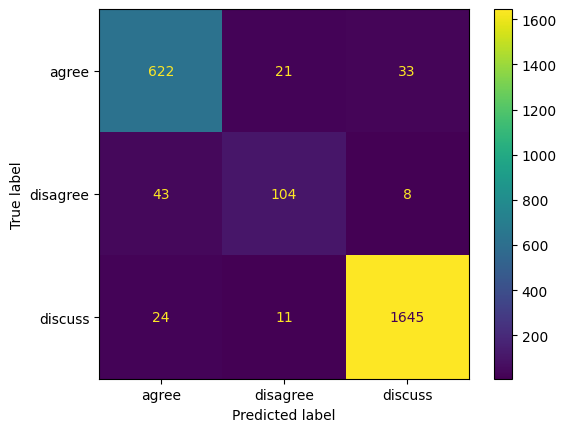

In [19]:
classifier.plot_cm(y_true, y_pred, labels=label_encoder.classes_)